# Ustawienie środowiska

In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from tensorflow import keras
from math import *

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from glob import glob

Using TensorFlow backend.


# Obróbka danych

W celu ułatwienia podzielimy dane na zbiór treningowy, testowy i walidacyjny. Korzystając z programu `podzial_na_train-test-val.py` w folderze projects. Program ten losowo wybiera po 5 obrazów dla zbioru testowego. 80% reszty dla zbioru trenigowego, a to, co zostało zapisuje w zbiór walidacyjny.  

Zamieszczamy poniżej kod niego, którego nie należy odpalać, jeśli został już raz odpalony (obrazy będą się dopisywać do folderów, w związku z tym zaczną się powtarzać).

In [ ]:
yes_dir = glob.glob('C:/git/obrazyMRI/data/brain_tumor_dataset/yes/*')
no_dir =glob.glob('C:/git/obrazyMRI/data/brain_tumor_dataset/no/*')

# define the name of the directory to be created
path = ["C:/git/obrazyMRI/data/TEST/YES","C:/git/obrazyMRI/data/TEST/NO", "C:/git/obrazyMRI/data/TRAIN/YES",
       "C:/git/obrazyMRI/data/TRAIN/NO", "C:/git/obrazyMRI/data/VAL/YES", "C:/git/obrazyMRI/data/VAL/NO"]
for i in path:
    try:
        os.makedirs(i)
    except OSError:
        print ("Creation of the directory %s failed" % i)
    else:
        print ("Successfully created the directory %s" % i)


yes_test=np.random.choice(yes_dir, size=5, replace=False)
for i in yes_test:
    shutil.copy(i, "C:/git/obrazyMRI/data/TEST/YES" )
yes_dir=list(set(yes_dir)-set(yes_test))
yes_train=np.random.choice(yes_dir, size=floor(0.8*len(yes_dir)), replace=False)
for i in yes_train:
    shutil.copy(i, "C:/git/obrazyMRI/data/TRAIN/YES" )
yes_val=list(set(yes_dir)-set(yes_train))
for i in yes_val:
    shutil.copy(i, "C:/git/obrazyMRI/data/VAL/YES" )


no_test=np.random.choice(no_dir, size=5, replace=False)
for i in no_test:
    shutil.copy(i, "C:/git/obrazyMRI/data/TEST/NO" )
no_dir=list(set(no_dir)-set(no_test))
no_train=np.random.choice(no_dir, size=floor(0.8*len(no_dir)), replace=False)
for i in no_train:
    shutil.copy(i, "C:/git/obrazyMRI/data/TRAIN/NO" )
no_val=list(set(no_dir)-set(no_train))
for i in no_val:
    shutil.copy(i, "C:/git/obrazyMRI/data/VAL/NO" )

Teraz skorzystamy z programu `load_data.py`, który załaduje nasze dane oraz dodatkowo je wyświetli. 

In [2]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


TRAIN_DIR = 'C:/git/obrazyMRI/data/TRAIN/'
TEST_DIR = 'C:/git/obrazyMRI/data/TEST/'
VAL_DIR = 'C:/git/obrazyMRI/data/VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]


194 images loaded from C:/git/obrazyMRI/data/TRAIN/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]


10 images loaded from C:/git/obrazyMRI/data/TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.82it/s]


49 images loaded from C:/git/obrazyMRI/data/VAL/ directory.


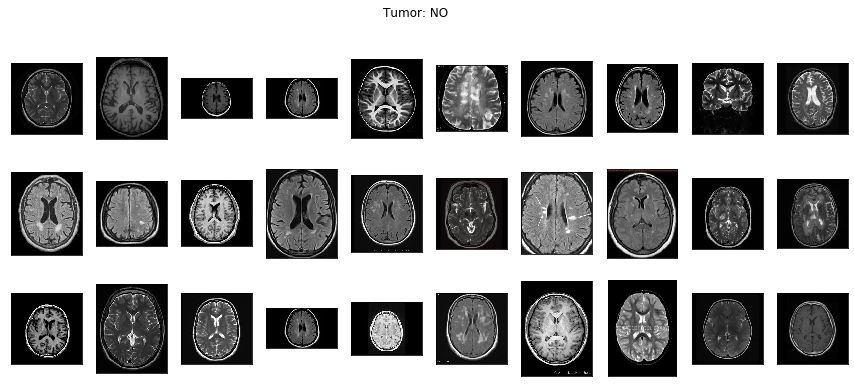

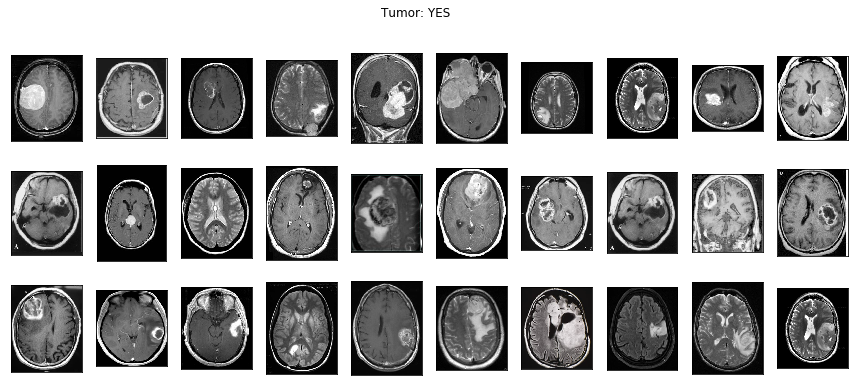

In [3]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()
        
plot_samples(X_train, y_train, labels, 30)     

Widzimy, że nasze zdjęcia mózgu są robione z różnej odległości. Spróbujemy je znormalizować tak, aby widoczny był mózg z jak najmniejszą ilością tła. W tym celu znajdziemy minimum i maksimum mózgu w pionie i poziomie. Zrobimy to techniką, która opisana jest na [stronie](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [4]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

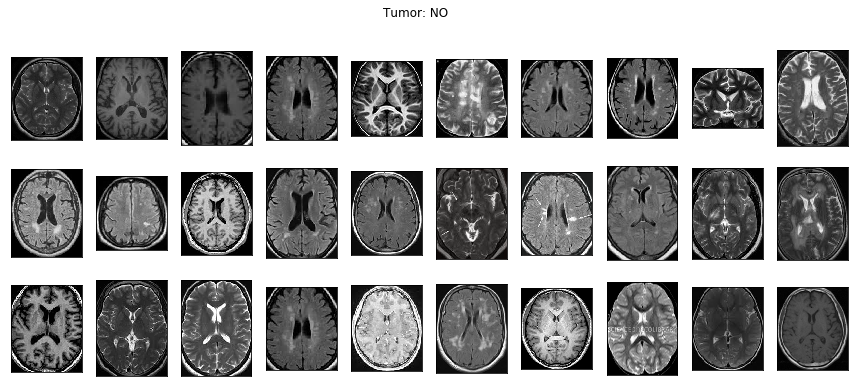

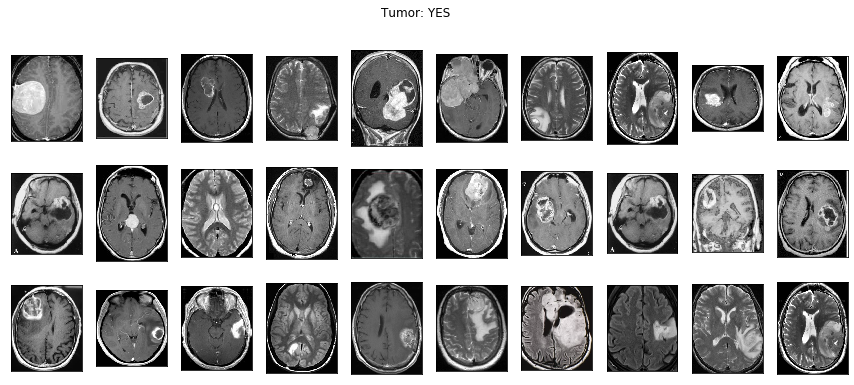

In [5]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

plot_samples(X_train_crop, y_train, labels, 30)

Teraz stworzymy foldery dla powyższych obrazów.

In [6]:
path = ["C:/git/obrazyMRI/data/TEST_CROP/YES","C:/git/obrazyMRI/data/TEST_CROP/NO", "C:/git/obrazyMRI/data/TRAIN_CROP/YES",
       "C:/git/obrazyMRI/data/TRAIN_CROP/NO", "C:/git/obrazyMRI/data/VAL_CROP/YES", "C:/git/obrazyMRI/data/VAL_CROP/NO"]
for i in path:
    try:
        os.makedirs(i)
    except OSError:
        print ("Creation of the directory %s failed" % i)
    else:
        print ("Successfully created the directory %s" % i)

Successfully created the directory C:/git/obrazyMRI/data/TEST_CROP/YES
Successfully created the directory C:/git/obrazyMRI/data/TEST_CROP/NO
Successfully created the directory C:/git/obrazyMRI/data/TRAIN_CROP/YES
Successfully created the directory C:/git/obrazyMRI/data/TRAIN_CROP/NO
Successfully created the directory C:/git/obrazyMRI/data/VAL_CROP/YES
Successfully created the directory C:/git/obrazyMRI/data/VAL_CROP/NO


I stworzymy funkcję, która zapisze obrazy w nowo powstałe foldery. 

In [7]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [8]:
save_new_images(X_train_crop, y_train, folder_name='C:/git/obrazyMRI/data/TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='C:/git/obrazyMRI/data/VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='C:/git/obrazyMRI/data/TEST_CROP/')

Obróbka danych jest już prawie skończona. Wystarczy jeszcze tylko ujednolicić rozmiar obrazów.  

In [9]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [10]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


Nasze obrazy mają teraz rozmiar 224 na 224 pikseli.

W związku z tym, że nasza baza danych jest bardzo ograniczona, powiększymy ją przerabiając obrazy, tak aby wciąż było widoczne gdzie jest nowotwór, a gdzie go nie ma. 

In [13]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [15]:
os.mkdir('pokazac')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='pokazac', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

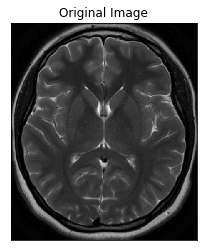

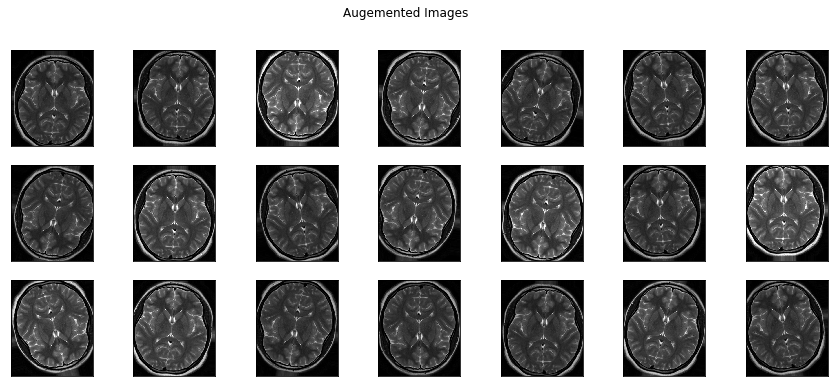

In [16]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('pokazac/'):
    img = cv2.cv2.imread('pokazac/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [18]:
TRAIN_DIR = 'C:/git/obrazyMRI/data/TRAIN_CROP/'
VAL_DIR = 'C:/git/obrazyMRI/data/VAL_CROP/'
RANDOM_SEED= 123

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 194 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


# Tworzenie modelu

Zastosujemy architekturę sieci VGG16. Mając na uwadze małą ilość naszych danych zastosujemy transfer learning, a konkretniej zbiór danych imagenet.

In [19]:
base_model = VGG16(weights='imagenet', input_shape=IMG_SIZE + (3,), include_top=False)

In [20]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 [==============================] - ETA: 31:59 - loss: 4.0682 - accuracy: 0.531 - ETA: 30:48 - loss: 5.0560 - accuracy: 0.531 - ETA: 29:05 - loss: 5.1414 - accuracy: 0.541 - ETA: 27:45 - loss: 5.2073 - accuracy: 0.531 - ETA: 25:38 - loss: 4.7587 - accuracy: 0.543 - ETA: 25:21 - loss: 5.0495 - accuracy: 0.531 - ETA: 21:30 - loss: 4.9900 - accuracy: 0.530 - ETA: 21:24 - loss: 4.8350 - accuracy: 0.548 - ETA: 20:44 - loss: 4.8974 - accuracy: 0.558 - ETA: 20:33 - loss: 4.7179 - accuracy: 0.575 - ETA: 18:20 - loss: 4.3116 - accuracy: 0.578 - ETA: 17:22 - loss: 4.4146 - accuracy: 0.583 - ETA: 16:27 - loss: 4.5925 - accuracy: 0.570 - ETA: 16:00 - loss: 4.6373 - accuracy: 0.572 - ETA: 15:46 - loss: 4.6768 - accuracy: 0.573 - ETA: 15:30 - loss: 4.6169 - accuracy: 0.581 - ETA: 14:14 - loss: 5.1293 - accuracy: 0.579 - ETA: 13:55 - loss: 5.0216 - accuracy: 0.582 - ETA: 13:41 - loss: 4.9884 - accuracy: 0.583 - ETA: 13:16 - loss: 4.8808 - accuracy: 0.590 - ETA: 13:01 - loss: 4.8180 - 

50/50 [==============================] - ETA: 37:08 - loss: 3.3372 - accuracy: 0.718 - ETA: 34:57 - loss: 2.7485 - accuracy: 0.687 - ETA: 30:18 - loss: 2.7370 - accuracy: 0.718 - ETA: 30:09 - loss: 2.1839 - accuracy: 0.750 - ETA: 28:22 - loss: 2.1013 - accuracy: 0.768 - ETA: 27:02 - loss: 1.9930 - accuracy: 0.776 - ETA: 22:49 - loss: 1.7083 - accuracy: 0.778 - ETA: 23:24 - loss: 1.8691 - accuracy: 0.774 - ETA: 24:14 - loss: 1.8194 - accuracy: 0.775 - ETA: 23:24 - loss: 1.9852 - accuracy: 0.762 - ETA: 22:36 - loss: 2.0455 - accuracy: 0.757 - ETA: 22:02 - loss: 2.0439 - accuracy: 0.762 - ETA: 21:30 - loss: 2.0452 - accuracy: 0.766 - ETA: 20:38 - loss: 2.0356 - accuracy: 0.767 - ETA: 19:50 - loss: 2.0883 - accuracy: 0.762 - ETA: 19:10 - loss: 1.9907 - accuracy: 0.771 - ETA: 17:44 - loss: 1.8736 - accuracy: 0.772 - ETA: 17:42 - loss: 1.8650 - accuracy: 0.771 - ETA: 16:44 - loss: 1.8528 - accuracy: 0.775 - ETA: 15:55 - loss: 1.8245 - accuracy: 0.782 - ETA: 14:41 - loss: 1.8763 - accuracy: 0

50/50 [==============================] - ETA: 21:50 - loss: 1.0319 - accuracy: 0.906 - ETA: 20:33 - loss: 2.0395 - accuracy: 0.843 - ETA: 13:47 - loss: 1.3597 - accuracy: 0.848 - ETA: 13:55 - loss: 1.5268 - accuracy: 0.816 - ETA: 13:55 - loss: 1.5628 - accuracy: 0.800 - ETA: 14:23 - loss: 1.5163 - accuracy: 0.821 - ETA: 13:52 - loss: 1.5743 - accuracy: 0.804 - ETA: 13:39 - loss: 1.5595 - accuracy: 0.809 - ETA: 13:19 - loss: 1.8617 - accuracy: 0.798 - ETA: 13:10 - loss: 1.8013 - accuracy: 0.803 - ETA: 14:16 - loss: 1.7131 - accuracy: 0.816 - ETA: 14:29 - loss: 1.8082 - accuracy: 0.819 - ETA: 14:43 - loss: 1.7956 - accuracy: 0.818 - ETA: 13:21 - loss: 1.6673 - accuracy: 0.819 - ETA: 13:07 - loss: 1.7208 - accuracy: 0.814 - ETA: 12:59 - loss: 1.7166 - accuracy: 0.814 - ETA: 12:56 - loss: 1.7390 - accuracy: 0.822 - ETA: 12:27 - loss: 1.7272 - accuracy: 0.825 - ETA: 11:28 - loss: 1.6363 - accuracy: 0.826 - ETA: 11:01 - loss: 1.6916 - accuracy: 0.820 - ETA: 10:46 - loss: 1.7220 - accuracy: 0

50/50 [==============================] - ETA: 14:53 - loss: 1.4314 - accuracy: 0.843 - ETA: 14:02 - loss: 1.1743 - accuracy: 0.890 - ETA: 13:27 - loss: 1.2190 - accuracy: 0.885 - ETA: 13:02 - loss: 1.2217 - accuracy: 0.875 - ETA: 13:26 - loss: 1.0030 - accuracy: 0.893 - ETA: 12:57 - loss: 1.1426 - accuracy: 0.890 - ETA: 12:30 - loss: 1.0092 - accuracy: 0.901 - ETA: 12:06 - loss: 1.2042 - accuracy: 0.875 - ETA: 11:44 - loss: 1.1815 - accuracy: 0.871 - ETA: 11:24 - loss: 1.0846 - accuracy: 0.881 - ETA: 10:11 - loss: 1.1449 - accuracy: 0.878 - ETA: 10:07 - loss: 1.1795 - accuracy: 0.878 - ETA: 9:52 - loss: 1.1952 - accuracy: 0.878 - ETA: 9:37 - loss: 1.2071 - accuracy: 0.87 - ETA: 9:22 - loss: 1.1342 - accuracy: 0.88 - ETA: 9:06 - loss: 1.1390 - accuracy: 0.88 - ETA: 8:50 - loss: 1.1084 - accuracy: 0.88 - ETA: 8:34 - loss: 1.0535 - accuracy: 0.88 - ETA: 7:55 - loss: 1.0667 - accuracy: 0.88 - ETA: 7:45 - loss: 1.0316 - accuracy: 0.88 - ETA: 7:31 - loss: 1.0729 - accuracy: 0.87 - ETA: 7:16 

In [22]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.86


In [23]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)


Test Accuracy = 0.90


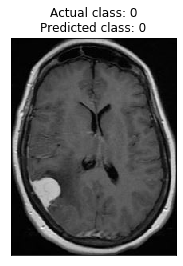

In [24]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

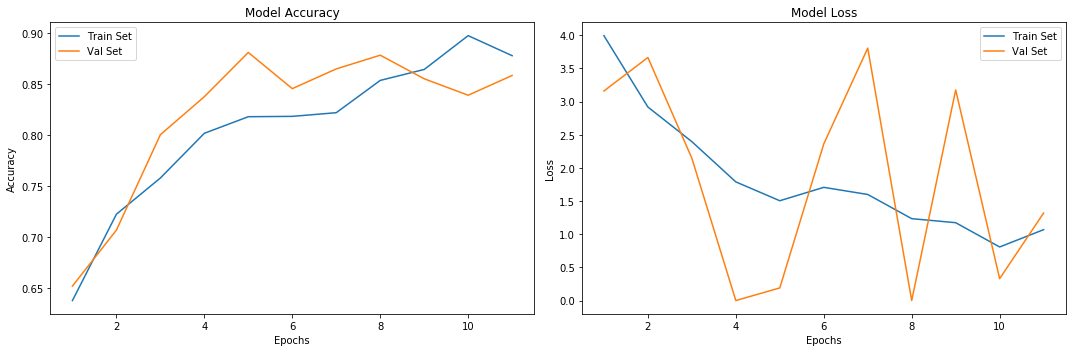

In [25]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Douczanie sieci

In [26]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 [==============================] - ETA: 24:42 - loss: 0.9186 - accuracy: 0.875 - ETA: 19:05 - loss: 0.5096 - accuracy: 0.921 - ETA: 16:58 - loss: 0.4426 - accuracy: 0.927 - ETA: 15:36 - loss: 0.6922 - accuracy: 0.914 - ETA: 14:49 - loss: 0.7442 - accuracy: 0.906 - ETA: 12:13 - loss: 0.7789 - accuracy: 0.901 - ETA: 12:15 - loss: 0.9043 - accuracy: 0.881 - ETA: 11:54 - loss: 1.0400 - accuracy: 0.876 - ETA: 11:34 - loss: 1.0323 - accuracy: 0.883 - ETA: 11:23 - loss: 1.1471 - accuracy: 0.872 - ETA: 11:10 - loss: 1.1806 - accuracy: 0.866 - ETA: 10:02 - loss: 1.0933 - accuracy: 0.867 - ETA: 9:52 - loss: 1.0840 - accuracy: 0.862 - ETA: 9:46 - loss: 1.0227 - accuracy: 0.86 - ETA: 9:31 - loss: 1.0253 - accuracy: 0.86 - ETA: 9:14 - loss: 0.9954 - accuracy: 0.86 - ETA: 8:58 - loss: 0.9453 - accuracy: 0.86 - ETA: 8:42 - loss: 0.9035 - accuracy: 0.87 - ETA: 8:26 - loss: 0.9445 - accuracy: 0.87 - ETA: 8:09 - loss: 0.9530 - accuracy: 0.87 - ETA: 7:33 - loss: 0.9076 - accuracy: 0.87 -

50/50 [==============================] - ETA: 21:10 - loss: 0.5094 - accuracy: 0.937 - ETA: 10:51 - loss: 1.6054 - accuracy: 0.911 - ETA: 11:23 - loss: 1.2183 - accuracy: 0.939 - ETA: 12:17 - loss: 0.9413 - accuracy: 0.949 - ETA: 12:08 - loss: 0.7748 - accuracy: 0.953 - ETA: 11:56 - loss: 0.6758 - accuracy: 0.944 - ETA: 11:39 - loss: 0.7061 - accuracy: 0.938 - ETA: 10:04 - loss: 0.6179 - accuracy: 0.938 - ETA: 9:58 - loss: 0.5771 - accuracy: 0.938 - ETA: 9:53 - loss: 0.5801 - accuracy: 0.93 - ETA: 9:58 - loss: 0.6060 - accuracy: 0.93 - ETA: 9:48 - loss: 0.5882 - accuracy: 0.92 - ETA: 9:34 - loss: 0.6578 - accuracy: 0.91 - ETA: 9:21 - loss: 0.6618 - accuracy: 0.91 - ETA: 8:32 - loss: 0.6176 - accuracy: 0.91 - ETA: 8:21 - loss: 0.5878 - accuracy: 0.91 - ETA: 8:16 - loss: 0.6323 - accuracy: 0.91 - ETA: 8:23 - loss: 0.6086 - accuracy: 0.91 - ETA: 8:12 - loss: 0.6078 - accuracy: 0.91 - ETA: 7:57 - loss: 0.6001 - accuracy: 0.91 - ETA: 7:42 - loss: 0.6282 - accuracy: 0.91 - ETA: 7:07 - loss: 

50/50 [==============================] - ETA: 30:50 - loss: 0.6390 - accuracy: 0.906 - ETA: 27:19 - loss: 0.4277 - accuracy: 0.937 - ETA: 24:30 - loss: 0.6267 - accuracy: 0.916 - ETA: 22:49 - loss: 0.6521 - accuracy: 0.914 - ETA: 22:36 - loss: 0.5751 - accuracy: 0.912 - ETA: 18:41 - loss: 0.4916 - accuracy: 0.913 - ETA: 20:25 - loss: 0.4903 - accuracy: 0.907 - ETA: 19:49 - loss: 0.5330 - accuracy: 0.902 - ETA: 18:54 - loss: 0.5775 - accuracy: 0.903 - ETA: 16:41 - loss: 0.5197 - accuracy: 0.903 - ETA: 15:55 - loss: 0.5255 - accuracy: 0.907 - ETA: 15:09 - loss: 0.5301 - accuracy: 0.907 - ETA: 14:27 - loss: 0.5105 - accuracy: 0.910 - ETA: 13:46 - loss: 0.5270 - accuracy: 0.912 - ETA: 13:57 - loss: 0.5208 - accuracy: 0.914 - ETA: 14:23 - loss: 0.5260 - accuracy: 0.915 - ETA: 14:14 - loss: 0.5861 - accuracy: 0.913 - ETA: 14:01 - loss: 0.5952 - accuracy: 0.914 - ETA: 13:47 - loss: 0.5774 - accuracy: 0.916 - ETA: 13:25 - loss: 0.5607 - accuracy: 0.917 - ETA: 12:23 - loss: 0.5340 - accuracy: 0

50/50 [==============================] - ETA: 22:10 - loss: 0.4974 - accuracy: 0.968 - ETA: 11:48 - loss: 0.6667 - accuracy: 0.941 - ETA: 14:50 - loss: 0.4521 - accuracy: 0.969 - ETA: 15:26 - loss: 0.4146 - accuracy: 0.959 - ETA: 16:28 - loss: 0.3646 - accuracy: 0.953 - ETA: 16:13 - loss: 0.4930 - accuracy: 0.938 - ETA: 15:45 - loss: 0.5779 - accuracy: 0.933 - ETA: 14:59 - loss: 0.5331 - accuracy: 0.933 - ETA: 14:30 - loss: 0.4833 - accuracy: 0.938 - ETA: 14:25 - loss: 0.4495 - accuracy: 0.941 - ETA: 14:03 - loss: 0.4091 - accuracy: 0.947 - ETA: 12:40 - loss: 0.3751 - accuracy: 0.947 - ETA: 12:55 - loss: 0.3541 - accuracy: 0.949 - ETA: 12:43 - loss: 0.3432 - accuracy: 0.948 - ETA: 12:24 - loss: 0.3626 - accuracy: 0.950 - ETA: 12:02 - loss: 0.3474 - accuracy: 0.951 - ETA: 11:40 - loss: 0.3295 - accuracy: 0.952 - ETA: 10:43 - loss: 0.3112 - accuracy: 0.952 - ETA: 10:36 - loss: 0.2968 - accuracy: 0.953 - ETA: 10:22 - loss: 0.2918 - accuracy: 0.952 - ETA: 9:34 - loss: 0.2779 - accuracy: 0.

In [28]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.90


In [29]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

Test Accuracy = 0.90


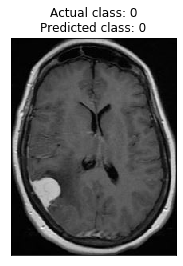

In [30]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

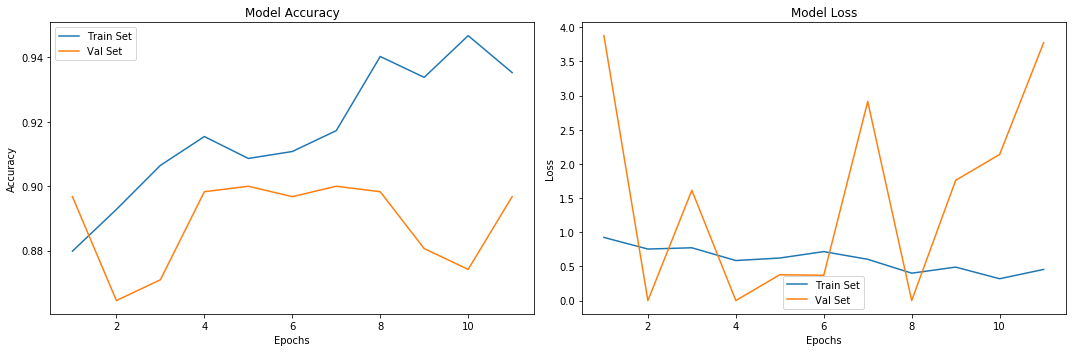

In [31]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Wnioski
Douczenie sieci za bardzo nic nie dało. Ewentualnie jako sukces można uznać wzrost trafności o 4% dla zbioru walidacyjnego, jednak jak widać z powyższych wykresów zbiór walidacyjny miał niemalże przez cały czas mniejszą trafność niż zbiór treningowy. Ogólnie możemy uznać, że model ma zadawalające wyniki, jednak dziwne jest dlaczego nie sklasyfikował jednego obrazka w zbiorze testowym. 

W ćwiczeniu najbardziej pracochłonne, oczywiście, było  przygotowanie danych. Okazało się też, że sama instalacja pakietów była lekkim wyzwaweniem. Warto również dodać, że sieć uczyła się mniej więcej 7 godzin. 